<a href="https://colab.research.google.com/github/WHU-Peter/COMP6200-Project/blob/main/vgg_model_comprasion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! /opt/bin/nvidia-smi

Thu Aug 19 17:52:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import math
import numpy as np

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4,
                                          shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4,
                                         shuffle=False)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
baseline_model = models.vgg16(pretrained=True).to(device)  # 使用VGG16 网络预训练好的模型

epoch = 30  #Training times
learning_rate = 1e-5  #Learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=learning_rate)
Loss_Baseline_Model = []

print('Baseline_Model Started Training')

for epoch in range(epoch):    #Iteration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
                 #Initialize gradient
        optimizer.zero_grad()

        outputs = baseline_model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # Print loss
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            Loss_Baseline_Model.append(running_loss)
            running_loss = 0.0

print('Baseline_Model Finished Training')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Baseline_Model Started Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 1.93624
[1,  4000] loss: 0.93179
[1,  6000] loss: 0.75061
[1,  8000] loss: 0.67463
[1, 10000] loss: 0.61091
[1, 12000] loss: 0.55943
[2,  2000] loss: 0.42958
[2,  4000] loss: 0.42993
[2,  6000] loss: 0.40983
[2,  8000] loss: 0.41355
[2, 10000] loss: 0.39910
[2, 12000] loss: 0.40420
[3,  2000] loss: 0.24903
[3,  4000] loss: 0.26369
[3,  6000] loss: 0.27917
[3,  8000] loss: 0.26300
[3, 10000] loss: 0.26058
[3, 12000] loss: 0.26039
[4,  2000] loss: 0.15450
[4,  4000] loss: 0.15064
[4,  6000] loss: 0.16846
[4,  8000] loss: 0.18007
[4, 10000] loss: 0.17980
[4, 12000] loss: 0.16427
[5,  2000] loss: 0.08981
[5,  4000] loss: 0.11735
[5,  6000] loss: 0.11035
[5,  8000] loss: 0.11948
[5, 10000] loss: 0.11573
[5, 12000] loss: 0.11647
[6,  2000] loss: 0.06952
[6,  4000] loss: 0.08555
[6,  6000] loss: 0.08027
[6,  8000] loss: 0.08851
[6, 10000] loss: 0.08592
[6, 12000] loss: 0.08377
[7,  2000] loss: 0.05952
[7,  4000] loss: 0.07139
[7,  6000] loss: 0.07047
[7,  8000] loss: 0.05587


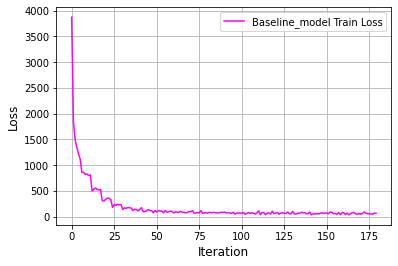

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,4))
ax.plot(Loss_Baseline_Model, Color='magenta', label='Baseline_model Train Loss')
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

In [6]:
correct = 0
total = 0
baseline_model.eval()
for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = baseline_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 87.95 %


In [7]:
def softmax_temperature(logits, temperature):
    pro = F.softmax(logits / temperature, dim=-1)
    return pro;

In [8]:
def mapping_onehot_vector(vector):
    return vector @ torch.LongTensor(range(0, vector.shape[1]))

In [9]:
class LearnableLookUpTable(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int, init_temperature: float):
        super(LearnableLookUpTable, self).__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.temperature = nn.Parameter(torch.tensor(init_temperature, requires_grad=True))

    def forward(self, x):
        # if self.training:
          x = softmax_temperature(x, self.temperature)
          return x @ self.emb.weight
        # else:
        #   x = softmax_temperature(x, 0.00001)
        #   x = mapping_onehot_vector(x)
        #   return self.emb(x)

In [10]:
class Learnable_VGG_LookUpTable(nn.Module):
  def __init__(self, originalModel, init_temperature):
    super(Learnable_VGG_LookUpTable, self).__init__()
    # self.features = originalModel.features
    # self.avgpool = originalModel.avgpool
    self.vgg = nn.Sequential(*list(originalModel.children())[:-1])
    # self.classifier = originalModel.classifier
    self.look_up_table = LearnableLookUpTable(25088, 4096, init_temperature)
    self.classifier = nn.Sequential(*list(originalModel.classifier.children())[1:])
    
  def forward(self, x):
    # x = self.features(x)
    # x = self.avgpool(x)
    x = self.vgg(x)
    x = x.view(x.size(0), -1)
    x = self.look_up_table(x)
    x = self.classifier(x)
    return x

In [11]:
pre_model = models.vgg16(pretrained=True)  # 使用VGG16 网络预训练好的模型
for parma in pre_model.parameters():  # 设置自动梯度为false
    parma.requires_grad = True
learnable_lut_model = Learnable_VGG_LookUpTable(pre_model, 1.).to(device)

epoches = 30  #Training times
learning_rate = 1e-5  #Learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(learnable_lut_model.parameters(), lr=learning_rate)
Loss_Learnable_Model = []
Temperature = []

print('Learnable_lut_model Started Training')
for epoch in range(epoches):    #Iteration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
                 #Initialize gradient
        optimizer.zero_grad()
        outputs = learnable_lut_model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # for parameter in optimizer.param_groups[0]['params']:
        #   print(np.any(parameter.grad.cpu().numpy()==0))

        # Print loss
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            Loss_Learnable_Model.append(running_loss)
            running_loss = 0.0

            for parameter in learnable_lut_model.named_parameters():
              if parameter[0] == 'look_up_table.temperature':
                print('[%d, %5d] temperature: %.5f' %
                  (epoch + 1, i + 1, parameter[1].data.detach().cpu().numpy()))
                Temperature.append(parameter[1].data.detach().cpu().numpy())

print('Learnable_lut_model Finished Training')

Learnable_lut_model Started Training
[1,  2000] loss: 3.10607
[1,  2000] temperature: 1.00095
[1,  4000] loss: 2.34491
[1,  4000] temperature: 1.00102
[1,  6000] loss: 1.91788
[1,  6000] temperature: 1.00184
[1,  8000] loss: 1.54783
[1,  8000] temperature: 1.00265
[1, 10000] loss: 1.40807
[1, 10000] temperature: 1.00336
[1, 12000] loss: 1.28738
[1, 12000] temperature: 1.00383
[2,  2000] loss: 1.14859
[2,  2000] temperature: 1.00387
[2,  4000] loss: 1.06961
[2,  4000] temperature: 1.00382
[2,  6000] loss: 1.01502
[2,  6000] temperature: 1.00392
[2,  8000] loss: 0.84538
[2,  8000] temperature: 1.00402
[2, 10000] loss: 0.68097
[2, 10000] temperature: 1.00419
[2, 12000] loss: 0.64636
[2, 12000] temperature: 1.00434
[3,  2000] loss: 0.48695
[3,  2000] temperature: 1.00385
[3,  4000] loss: 0.48782
[3,  4000] temperature: 1.00383
[3,  6000] loss: 0.44341
[3,  6000] temperature: 1.00373
[3,  8000] loss: 0.46978
[3,  8000] temperature: 1.00390
[3, 10000] loss: 0.44992
[3, 10000] temperature: 1.

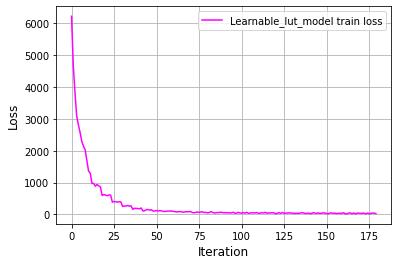

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,4))
ax.plot(Loss_Learnable_Model, Color='magenta', label='Learnable_lut_model train loss')
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

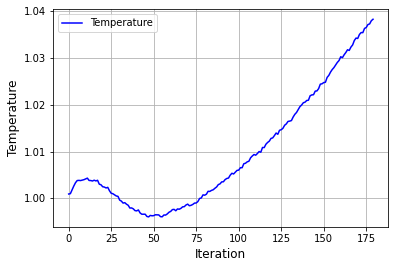

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,4))
ax.plot(Temperature, Color='blue', label='Temperature')
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Temperature", fontsize=12)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

In [14]:
correct = 0
total = 0
learnable_lut_model.eval()
for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = learnable_lut_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 88.65 %


In [15]:
class AnnealingLookUpTable(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super(AnnealingLookUpTable, self).__init__()
        self.embedding_dim = embedding_dim
        self.emb = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x, temperature):
        if self.training:
          x = softmax_temperature(x, temperature)
          return x @ self.emb.weight
        else:
          # x = softmax_temperature(x, 0.00001)
          # x = mapping_onehot_vector(x)
          # return self.emb(x)

          x = softmax_temperature(x, temperature)
          nozero = torch.nonzero(x);
          out = np.zeros((x.shape[0], self.embedding_dim))
          out = torch.tensor(out).to(device)
          # print(np.array(nozero).shape[1])
          for i in range(x.shape[0]):
            idx = torch.where(nozero[:,0]==i)[0]
            rows = nozero[idx, 1].long()
            out[i] = torch.mean(self.emb(rows), axis=0)
          return out.float()

In [16]:
class Annealing_VGG_LookUpTable(nn.Module):
  def __init__(self, originalModel):
    super(Annealing_VGG_LookUpTable, self).__init__()
    # self.features = originalModel.features
    # self.avgpool = originalModel.avgpool
    self.vgg = nn.Sequential(*list(originalModel.children())[:-1])
    # self.classifier = originalModel.classifier
    self.look_up_table = AnnealingLookUpTable(25088, 4096)
    self.classifier = nn.Sequential(*list(originalModel.classifier.children())[1:])
    
  def forward(self, x, temperature):
    # x = self.features(x)
    # x = self.avgpool(x)
    x = self.vgg(x)
    x = x.view(x.size(0), -1)
    x = self.look_up_table(x, temperature)
    x = self.classifier(x)
    return x

In [28]:
pre_model = models.vgg16(pretrained=True)  # 使用VGG16 网络预训练好的模型
for parma in pre_model.parameters():  # 设置自动梯度为false
    parma.requires_grad = True
Annealing_lut_model = Annealing_VGG_LookUpTable(pre_model).to(device)

epoches = 30  #Training times
learning_rate = 1e-5  #Learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Annealing_lut_model.parameters(), lr=learning_rate)
Loss_Annealing_Model = []
idx = 0

print('Loss_Annealing_Model Started Training')
for epoch in range(epoches):    #Iteration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        idx = idx + 1
        inputs, labels = data
                 #Initialize gradient
        optimizer.zero_grad()
        outputs = Annealing_lut_model(inputs.to(device), torch.tensor(max(0.0001, math.exp(-1.4 * math.pow(10, -5) * idx)), device= device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # for parameter in optimizer.param_groups[0]['params']:
        #   print(np.any(parameter.grad.cpu().numpy()==0))

        # Print loss
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            Loss_Annealing_Model.append(running_loss)
            running_loss = 0.0

print('Loss_Annealing_Model Finished Training')

Loss_Annealing_Model Started Training
[1,  2000] loss: 3.11555
[1,  4000] loss: 2.34511
[1,  6000] loss: 2.34364
[1,  8000] loss: 2.05007
[1, 10000] loss: 1.63050
[1, 12000] loss: 1.39897
[2,  2000] loss: 1.12111
[2,  4000] loss: 1.02716
[2,  6000] loss: 0.95111
[2,  8000] loss: 0.82554
[2, 10000] loss: 0.74199
[2, 12000] loss: 0.66303
[3,  2000] loss: 0.50422
[3,  4000] loss: 0.47724
[3,  6000] loss: 0.45666
[3,  8000] loss: 0.44798
[3, 10000] loss: 0.43532
[3, 12000] loss: 0.42231
[4,  2000] loss: 0.27615
[4,  4000] loss: 0.28397
[4,  6000] loss: 0.27278
[4,  8000] loss: 0.27638
[4, 10000] loss: 0.29253
[4, 12000] loss: 0.28832
[5,  2000] loss: 0.15602
[5,  4000] loss: 0.17135
[5,  6000] loss: 0.17563
[5,  8000] loss: 0.17028
[5, 10000] loss: 0.17346
[5, 12000] loss: 0.17574
[6,  2000] loss: 0.09622
[6,  4000] loss: 0.10634
[6,  6000] loss: 0.11049
[6,  8000] loss: 0.10961
[6, 10000] loss: 0.11383
[6, 12000] loss: 0.12097
[7,  2000] loss: 0.06110
[7,  4000] loss: 0.07091
[7,  6000] l

In [37]:
correct = 0
total = 0
Annealing_lut_model.eval()
for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = Annealing_lut_model(images, 0.0001)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 84.01 %


In [30]:
print(idx)
print(math.exp(-1.4 * math.pow(10, -5) * idx))

375000
0.005247518399181385


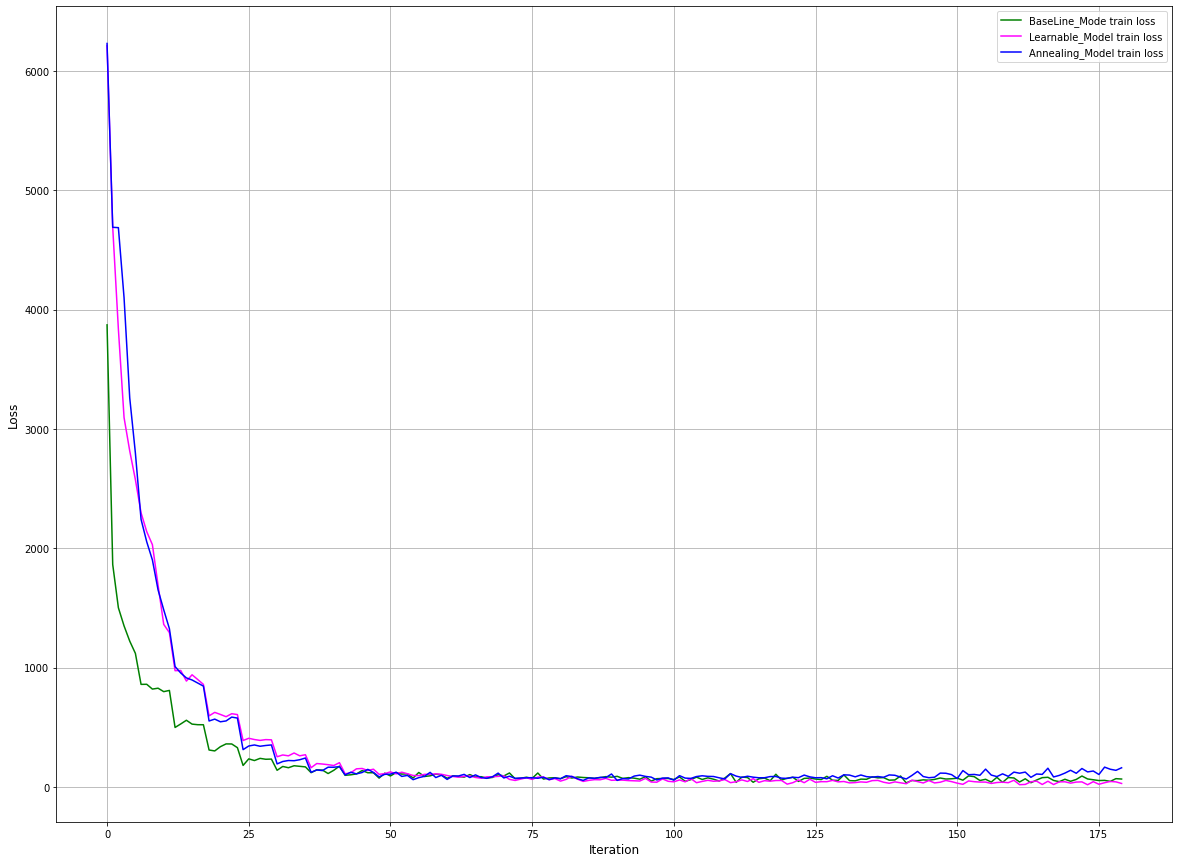

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,15))
ax.plot(Loss_Baseline_Model, Color='green', label='BaseLine_Mode train loss')
ax.plot(Loss_Learnable_Model, Color='magenta', label='Learnable_Model train loss')
ax.plot(Loss_Annealing_Model, Color='blue', label='Annealing_Model train loss')
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

In [32]:
logits = torch.FloatTensor([1, 2, 3, 4])

low_temp = 0.5
logits_low_temp = F.softmax(logits / low_temp, dim=-1)
print(logits_low_temp)

tensor([0.0021, 0.0158, 0.1171, 0.8650])


In [33]:
high_temp = 5
logits_high_temp = F.softmax(logits / high_temp, dim=-1)
print(logits_high_temp)

tensor([0.1807, 0.2207, 0.2695, 0.3292])


In [38]:
print(Loss_Baseline_Model)

[3872.4723823554814, 1863.5793002019636, 1501.223158330802, 1349.2540111092385, 1221.8130096917157, 1118.8604160515824, 859.1576800966432, 859.8661447088098, 819.6694815727824, 827.1000121614488, 798.2041533824977, 808.4048638707463, 498.0559452059506, 527.3723640723008, 558.3351522767725, 526.0050897749522, 521.1613981830073, 520.7777481278794, 308.995667043178, 301.2820669818178, 336.91673734006577, 360.1487615352137, 359.5988904956185, 328.53010717166296, 179.61531050015392, 234.69278697661755, 220.69319845028116, 238.96496242420662, 231.45076282694504, 232.93256985726043, 139.0307325424412, 171.09906588262777, 160.53744012389538, 177.01450049418492, 171.83414549059944, 167.54262140477843, 119.0473997492023, 142.78874401193275, 140.93155763452728, 111.74711841836245, 138.90022822534632, 174.03522936781852, 97.02349838853645, 101.2056621288282, 108.33963276619366, 136.8385455312183, 118.43028946202854, 118.41986965166821, 73.5163950850706, 115.02205457964922, 91.50348705507238, 119.8

In [39]:
print(Loss_Learnable_Model)

[6212.137823939323, 4689.819548845291, 3835.760307788849, 3095.6531695127487, 2816.142440855503, 2574.7640249729156, 2297.180137991905, 2139.2169994413853, 2030.0441165566444, 1690.7630194425583, 1361.949716359377, 1292.7211251929402, 973.9023675331846, 975.6482531530783, 886.8227000329643, 939.5573817854747, 899.8487724782899, 858.8820755546913, 595.1703743245453, 624.4764438553248, 607.0883182948455, 588.2957721748389, 613.2360910349526, 605.9834671209101, 388.4097411748953, 407.37585869571194, 396.7979876487516, 389.64830555883236, 396.1113784094341, 394.3182215037523, 252.3591319003026, 267.4459488361899, 260.20063259539893, 284.0571354191634, 260.405598602767, 269.4163694730669, 160.7044197198702, 195.61299871242954, 191.46402162931918, 185.99093928234652, 179.13650948031864, 202.78649691299506, 109.70876720805973, 118.22431438843341, 151.27373009996518, 154.23891497226214, 137.5814643246631, 148.10607673851155, 105.06861610508349, 111.35470533634361, 125.58070031628449, 108.96840

In [40]:
print(Loss_Annealing_Model)

[6231.092164993286, 4690.212652802467, 4687.280135750771, 4100.131859660149, 3260.990114212036, 2797.9389079511166, 2242.2153088748455, 2054.326329395175, 1902.2268817424774, 1651.0858060084283, 1483.9742424245924, 1326.0508961277083, 1008.449092803523, 954.4897480243817, 913.322356577497, 895.9502169264015, 870.6353339552879, 844.6116244744044, 552.3058530569542, 567.9375108380336, 545.5687112492742, 552.76754801278, 585.0532651745016, 576.6419852110557, 312.03054498974234, 342.70576283481205, 351.26043109592865, 340.555844418559, 346.91504351084586, 351.47508456831565, 192.43178626976442, 212.68704608397093, 220.97180833879975, 219.21986336936243, 227.65297506190836, 241.9382052024448, 122.19085505481053, 141.81727216899162, 136.53786210238468, 164.95525408505637, 164.67899104962999, 169.54875132197049, 100.14821060928807, 122.93376173271099, 108.93345714772295, 120.32376036408095, 146.91766293521505, 121.38307090081071, 84.03621486754855, 105.16295000497485, 106.42995667358628, 123.

In [48]:
print(Temperature)

[array(1.0009549, dtype=float32), array(1.0010239, dtype=float32), array(1.0018402, dtype=float32), array(1.0026482, dtype=float32), array(1.0033563, dtype=float32), array(1.0038255, dtype=float32), array(1.0038658, dtype=float32), array(1.0038241, dtype=float32), array(1.0039233, dtype=float32), array(1.0040168, dtype=float32), array(1.004189, dtype=float32), array(1.0043427, dtype=float32), array(1.0038475, dtype=float32), array(1.0038286, dtype=float32), array(1.0037305, dtype=float32), array(1.0039041, dtype=float32), array(1.0037453, dtype=float32), array(1.0038844, dtype=float32), array(1.0030531, dtype=float32), array(1.0029262, dtype=float32), array(1.002507, dtype=float32), array(1.0024364, dtype=float32), array(1.0022426, dtype=float32), array(1.002375, dtype=float32), array(1.0016472, dtype=float32), array(1.0011163, dtype=float32), array(1.0010129, dtype=float32), array(1.0007724, dtype=float32), array(1.0005331, dtype=float32), array(1.0004547, dtype=float32), array(0.9996